# Tratamento dos dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [3]:
base = pd.read_csv('petr4_treinamento_ex.csv')
base

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
...,...,...,...,...,...,...,...
1340,2018-05-21,26.100000,26.290001,24.940001,25.049999,25.000000,75971900.0
1341,2018-05-22,24.809999,25.290001,24.150000,24.709999,24.709999,88109900.0
1342,2018-05-23,24.230000,24.480000,23.270000,23.270000,23.270000,74622500.0
1343,2018-05-24,20.049999,20.750000,19.650000,20.080000,20.080000,240343800.0


In [4]:
base.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
base

,Date,Close
0,2013-01-02,19.690001
1,2013-01-03,20.400000
2,2013-01-04,20.430000
3,2013-01-07,20.080000
4,2013-01-08,19.500000
...,...,...
1340,2018-05-21,25.049999
1341,2018-05-22,24.709999
1342,2018-05-23,23.270000
1343,2018-05-24,20.080000


In [5]:
base.isnull().sum()

Date     0
Close    3
dtype: int64

In [6]:
base.dropna(inplace = True)

In [7]:
base.isnull().sum()

Date     0
Close    0
dtype: int64

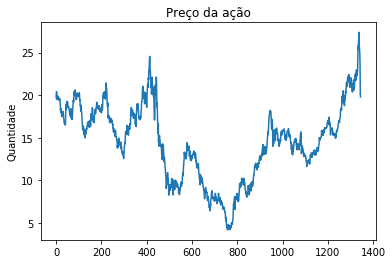

In [8]:
plt.plot(base['Close'])
plt.ylabel('Quantidade')
plt.title('Preço da ação')
plt.show()

# Configurações do SageMaker

In [9]:
import boto3
import sagemaker
from sagemaker import RandomCutForest

In [10]:
session = sagemaker.Session()
bucket = 'cursoawssagemaker'
subpasta_dataset = 'datasets/petr/random-cut'
subpasta_modelo = 'modelos/petr/random-cut'
key = 'petr-random-cut'
s3_data = 's3://{}/{}/{}'.format(bucket, subpasta_dataset, key)
output_location = 's3://{}/{}'.format(bucket, subpasta_modelo)
role = sagemaker.get_execution_role()
boto3.Session().client('s3').head_bucket(Bucket = bucket)
print('Localização da base de dados: ', s3_data)
print('Modelo será salvo em: ', output_location)

Localização da base de dados:  s3://cursoawssagemaker/datasets/petr/random-cut/petr-random-cut
Modelo será salvo em:  s3://cursoawssagemaker/modelos/petr/random-cut


# Treinamento do Random Cut

In [11]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html
# https://docs.aws.amazon.com/sagemaker/latest/dg/rcf_hyperparameters.html
# https://sagemaker.readthedocs.io/en/stable/algorithms/sagemaker.amazon.amazon_estimator.html
random_cut = RandomCutForest(role=role,
                      instance_count=1,
                      instance_type='ml.m4.xlarge',
                      data_location=s3_data,
                      output_path=output_location,
                      use_spot_instances=True,
                      max_run=3600,
                      max_wait=3600,
                      repo_version = 'latest')
random_cut.fit(random_cut.record_set(base['Close'].to_numpy().reshape(-1,1)))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-05-23 18:49:11 Starting - Starting the training job...
2022-05-23 18:49:13 Starting - Launching requested ML instancesProfilerReport-1653331751: InProgress
.........
2022-05-23 18:51:02 Starting - Preparing the instances for training...............
2022-05-23 18:53:25 Downloading - Downloading input data
2022-05-23 18:53:25 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/23/2022 18:53:51 INFO 140285801891648] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[05/23/2022 18:53:51 INFO 140285801891648] Merging with pro

# Deploy e inferência

In [12]:
random_cut_petr = random_cut.deploy(initial_instance_count=1,instance_type='ml.m5.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


------!

In [13]:
print('Endpoint: ', random_cut_petr.endpoint_name)

Endpoint:  randomcutforest-2022-05-23-18-55-49-170


In [14]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
random_cut_petr.serializer = CSVSerializer()
random_cut_petr.deserializer = JSONDeserializer()

In [15]:
base_numpy = base['Close'].to_numpy().reshape(-1,1)
base_numpy[0:5]

array([[19.690001],
       [20.4     ],
       [20.43    ],
       [20.08    ],
       [19.5     ]])

In [ ]:
previsoes = random_cut_petr.predict(base_numpy)
previsoes

In [17]:
previsoes = [p['score'] for p in previsoes['scores']]

In [18]:
previsoes[0:5]

[2.7971750841, 2.8774426043, 2.8823349925, 2.8274339235, 2.7802088451]

In [19]:
base['score'] = pd.Series(previsoes, index = base.index)
base

,Date,Close,score
0,2013-01-02,19.690001,2.797175
1,2013-01-03,20.400000,2.877443
2,2013-01-04,20.430000,2.882335
3,2013-01-07,20.080000,2.827434
4,2013-01-08,19.500000,2.780209
...,...,...,...
1340,2018-05-21,25.049999,3.352698
1341,2018-05-22,24.709999,3.335162
1342,2018-05-23,23.270000,3.248242
1343,2018-05-24,20.080000,2.827434


In [20]:
min(previsoes), max(previsoes), 1.4 * max(previsoes)

(2.4664691709, 3.4328370796, 4.8059719114399995)

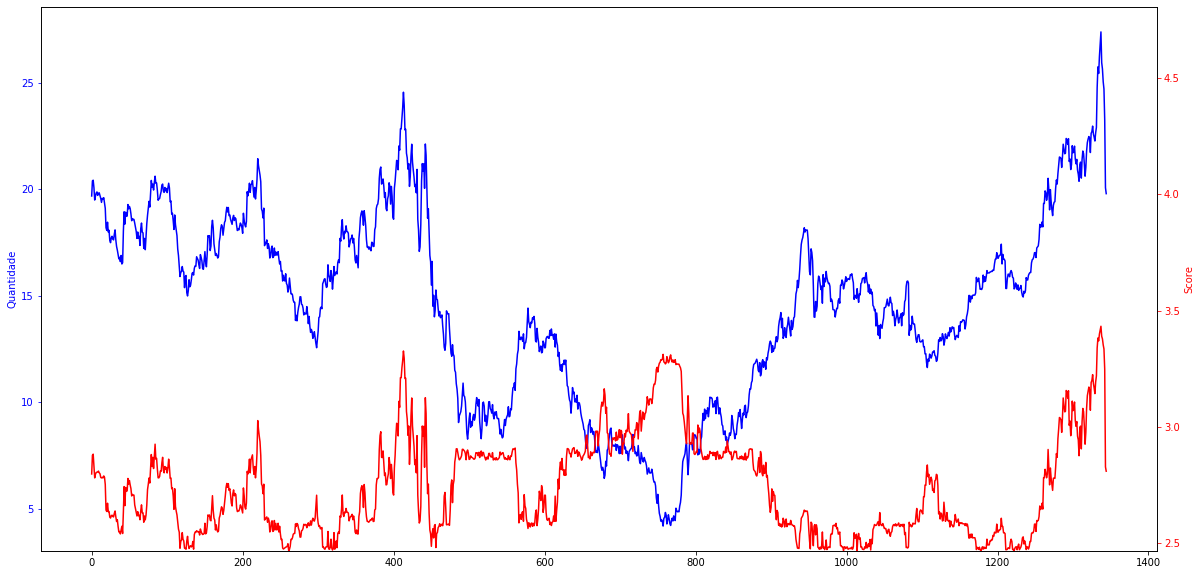

In [21]:
fig, ax1 = plt.subplots(figsize=(20,10))
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html
ax2 = ax1.twinx()

ax1.plot(base['Close'], color='blue')
ax2.plot(base['score'], color='red')

ax1.set_ylabel('Quantidade', color='blue')
ax2.set_ylabel('Score', color='red')

ax1.tick_params('y', colors='blue')
ax2.tick_params('y', colors='red')

ax2.set_ylim(min(previsoes), 1.4 * max(previsoes));

In [22]:
media_score = base['score'].mean()
media_score

2.739417634025782

In [23]:
desvio_padrao_score = base['score'].std()
desvio_padrao_score

0.21234120478216562

In [24]:
corte_score = media_score + 3 * desvio_padrao_score
corte_score

3.376441248372279

In [25]:
outliers = base[base['score'] > corte_score]
outliers

,Date,Close,score
1333,2018-05-10,25.750000,3.382378
1335,2018-05-14,26.240000,3.399689
1336,2018-05-15,26.790001,3.416658
1337,2018-05-16,27.389999,3.432837
1338,2018-05-17,25.950001,3.389729
1339,2018-05-18,25.650000,3.378538


In [27]:
base.describe()

,Close,score
count,1342.000000,1342.000000
mean,14.538964,2.739418
std,4.437737,0.212341
min,4.200000,2.466469
25%,11.565000,2.572538
50%,15.020000,2.674673
75%,17.827500,2.879555
max,27.389999,3.432837


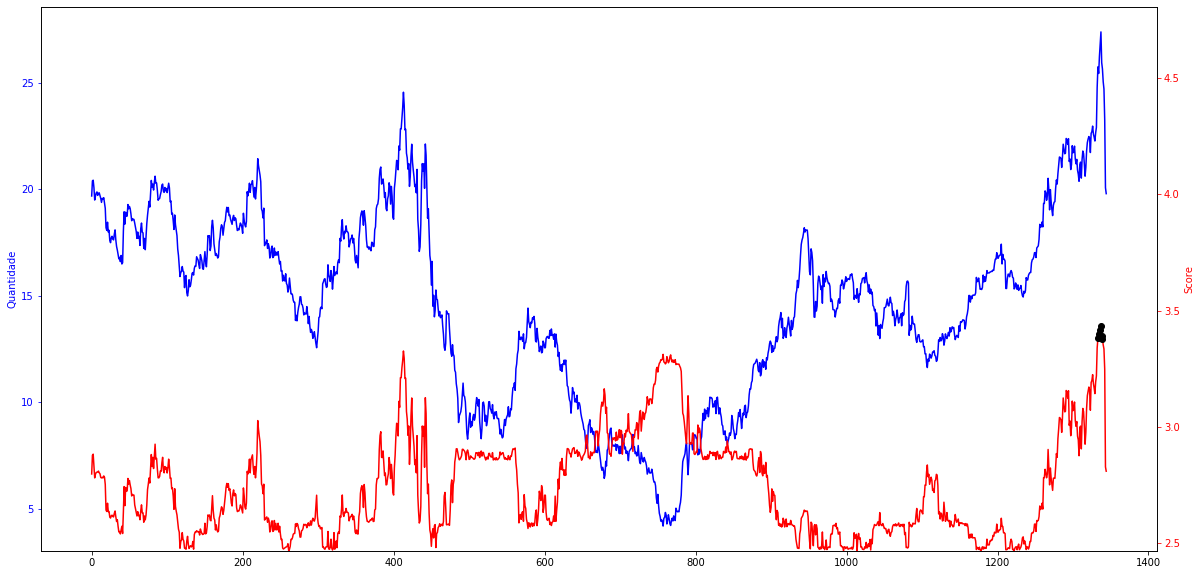

In [26]:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
ax2.plot(outliers.index, outliers['score'], 'ko')
fig

In [28]:
random_cut_petr.delete_endpoint()